# Predicció del Preu de Jugadors FIFA
## 1. Introducció
En el món del futbol, el valor de mercat d’un jugador es determina per una combinació complexa d’habilitats, atributs físics i reputació. El nostre objectiu és construir un model de *machine learning* capaç de predir aquest valor (`value_euro`) a partir d’estadístiques dels jugadors.

## L’enfocament
1. **Anàlisi exploratòria de dades (EDA)**
2. **Preprocessament**
3. **Enginyeria de característiques**
4. **Selecció de característiques (RFE)**
5. **Models i interpretabilitat (SHAP)**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error


# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Anàlisi Exploratori de Dades (EDA)
Abans de construir models, necessitem entendre bé les dades: distribucions, valors extrems, correlacions i possibles problemes.

In [4]:
df = pd.read_csv("fifa_players.csv")
print(f"Dataset Shape: {df.shape}")
df.head()




Dataset Shape: (17954, 51)


,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


In [5]:


df.keys()

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')

In [6]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

value_euro                 1.420296
wage_euro                  1.370168
release_clause_euro       10.231703
national_team             95.226690
national_rating           95.226690
national_team_position    95.226690
national_jersey_number    95.226690
dtype: float64

Número de NaNs per columna:

value_euro                  255
wage_euro                   246
release_clause_euro        1837
national_team             17097
national_rating           17097
national_team_position    17097
national_jersey_number    17097
dtype: int64


In [7]:

# Seleccionar només columnes numèriques
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Omplir NaNs amb la mediana de cada columna
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [8]:
df = df.drop(columns=["birth_date", "full_name","name"])
df.keys()

Index(['age', 'height_cm', 'weight_kgs', 'positions', 'nationality',
       'overall_rating', 'potential', 'value_euro', 'wage_euro',
       'preferred_foot', 'international_reputation(1-5)', 'weak_foot(1-5)',
       'skill_moves(1-5)', 'body_type', 'release_clause_euro', 'national_team',
       'national_rating', 'national_team_position', 'national_jersey_number',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')

### 2.1 Anàlisi de la Variable Objectiu
La distribució dels valors dels jugadors tendeix a ser molt asimètrica: pocs jugadors valen moltíssims diners i la majoria tenen valors molt més baixos. Visualitzem-ho.

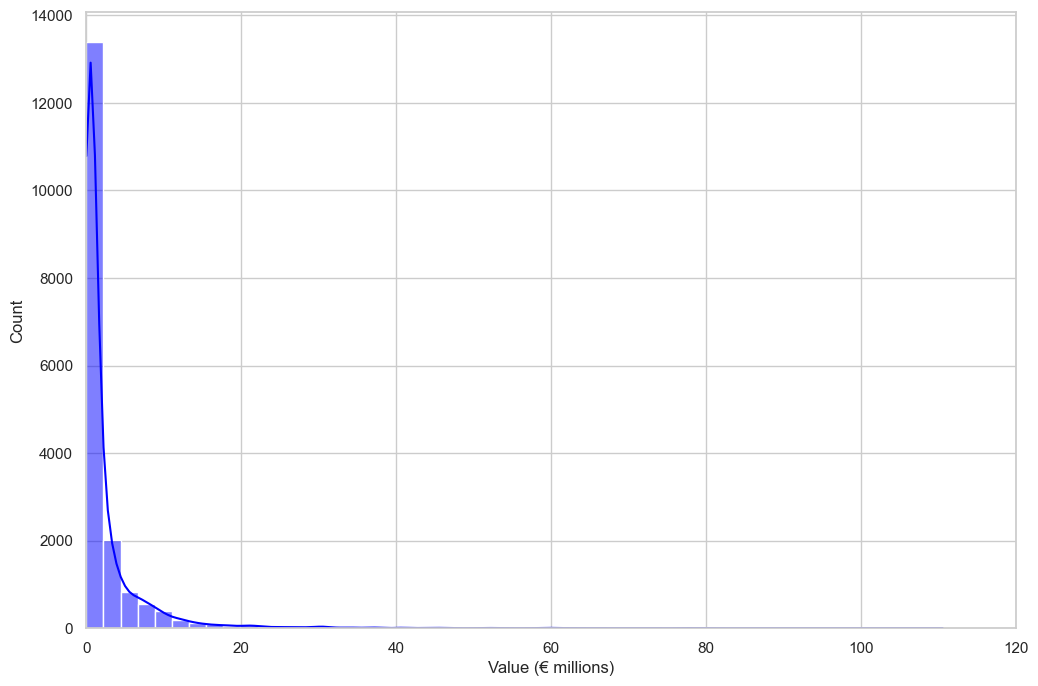

In [9]:
df['value_million'] = df['value_euro'] / 1_000_000
df.drop(columns=['value_euro'])
sns.histplot(df['value_million'], kde=True, bins=50, color='blue')
plt.xlabel("Value (€ millions)")
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0, 120)   # límit de 0 a 120 milions €
plt.ticklabel_format(style='plain', axis='x')

plt.show()
#gràfic sencer de la distribució de value_euro
#veiem que les dades estan molt concentrades a la part baixa de valors, per tant fem zoom a la part alta

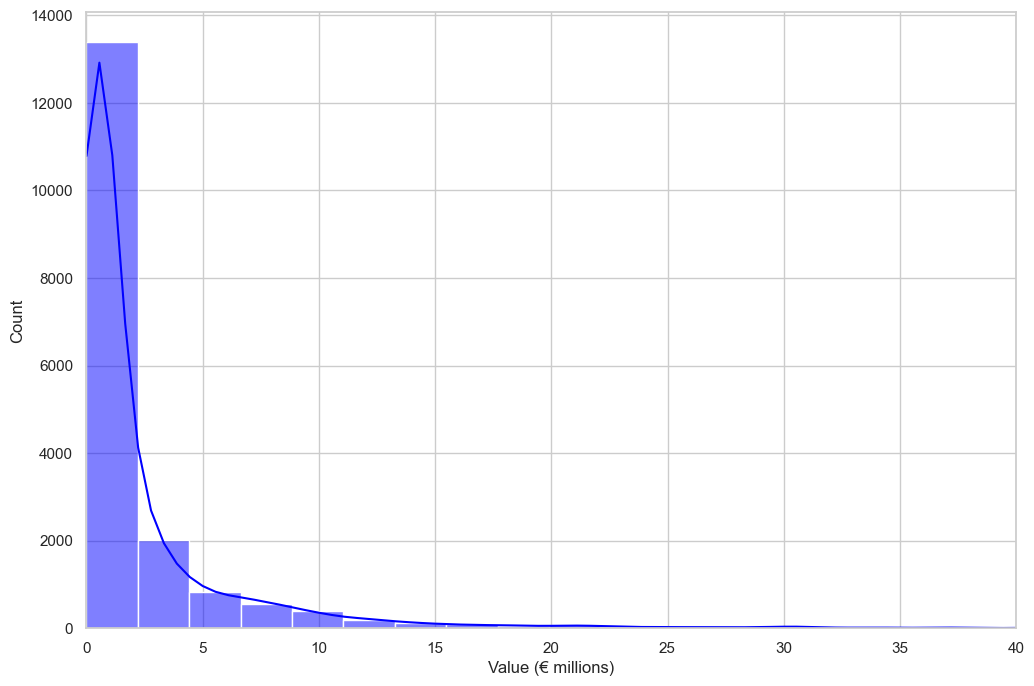

In [10]:

sns.histplot(df['value_million'], kde=True, bins=50, color='blue')
plt.xlabel("Value (€ millions)")
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0, 40)   # límit de 0 a 40 milions €
plt.ticklabel_format(style='plain', axis='x')

plt.show()
#on esta la majoria de individus

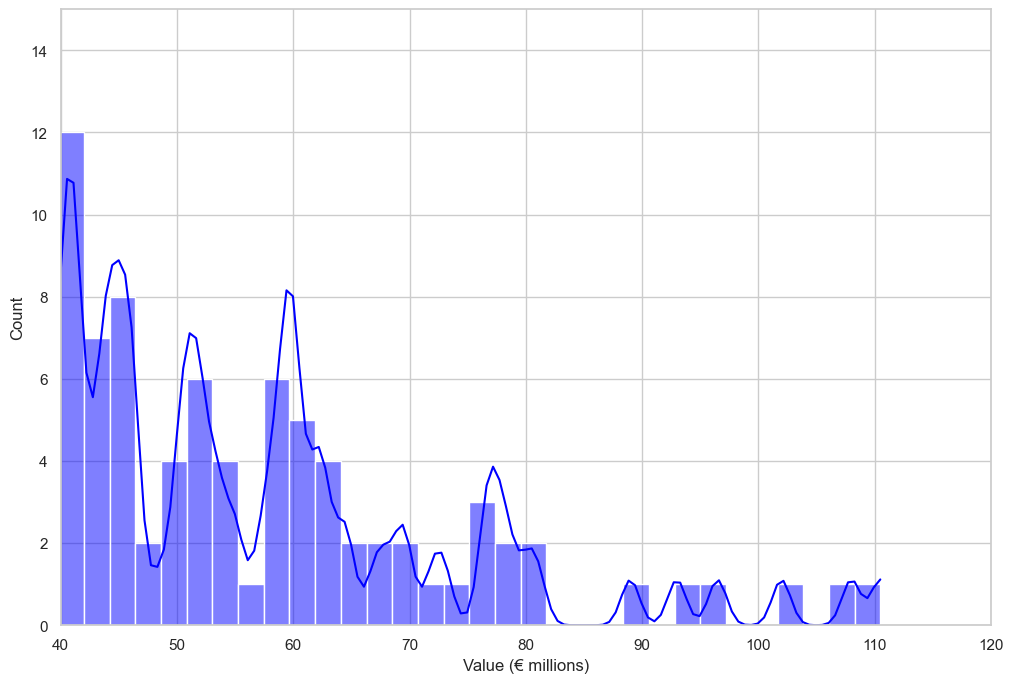

In [11]:

sns.histplot(df['value_million'], kde=True, bins=50, color='blue')
plt.xlabel("Value (€ millions)")
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(40, 120)   # límit de 40 a 120 milions €
plt.ticklabel_format(style='plain', axis='x')
plt.ylim(0, 15)   # límit de 0 a 15 jugadors
plt.show()
#porcentatge molt baix de jugadors tant cars

### 2.2 Detecció de Valors Extrems
Els valors extrems poden distorsionar els models. Utilitzarem *boxplots* per identificar possibles outliers en `overall_rating`, `potential` i `wage_euro`.

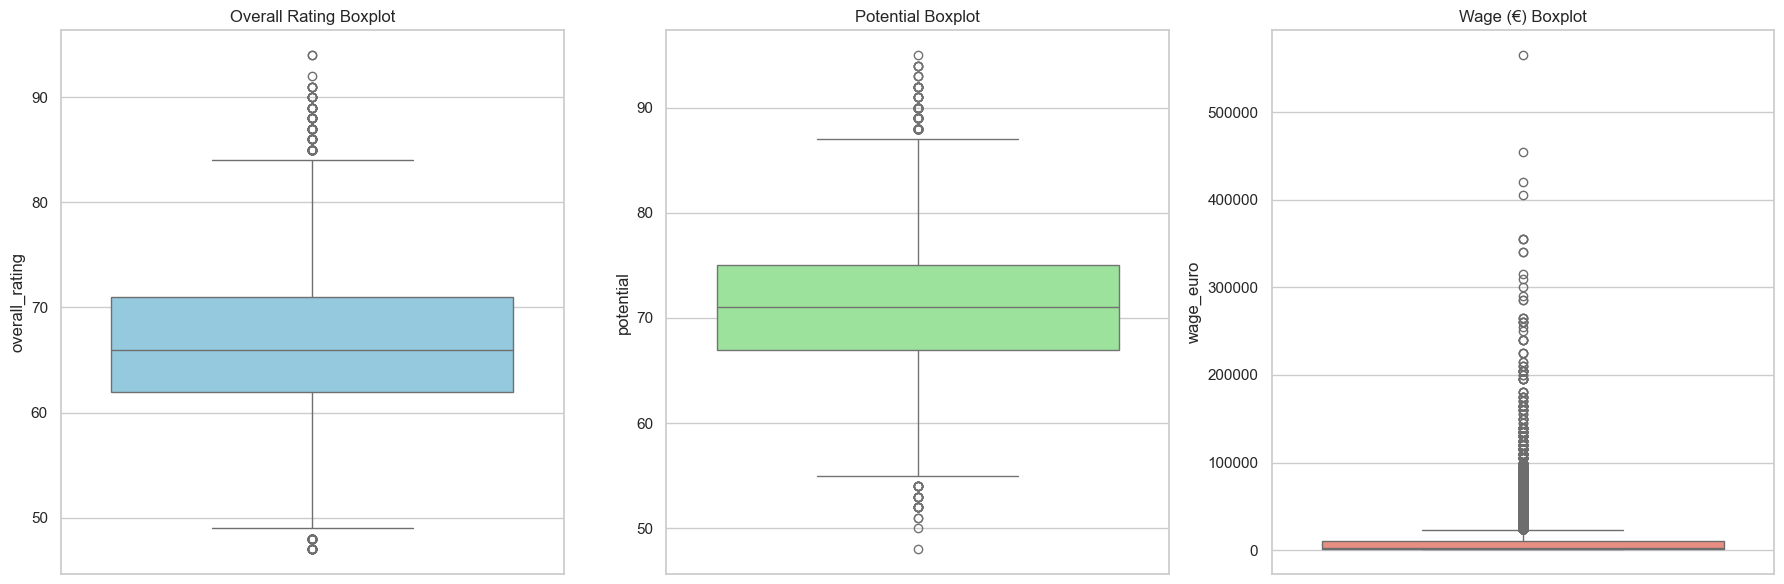

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(y=df['overall_rating'], ax=axes[0], color='skyblue')
axes[0].set_title('Overall Rating Boxplot')

sns.boxplot(y=df['potential'], ax=axes[1], color='lightgreen')
axes[1].set_title('Potential Boxplot')

if 'wage_euro' in df.columns:
    sns.boxplot(y=df['wage_euro'], ax=axes[2], color='salmon')
    axes[2].set_title('Wage (€) Boxplot')

plt.tight_layout()
plt.show()
#la boxplot de wage euro es tan "aplastada" perque la majoria de valors son molt baixos
#hi ha molts valors extrems en wage euro

### 2.3 Anàlisi de Correlació
Quines característiques influeixen més en el valor del jugador? Crearem un mapa de calor per trobar correlacions fortes. S’espera que `overall_rating` i `potential` siguin determinants.

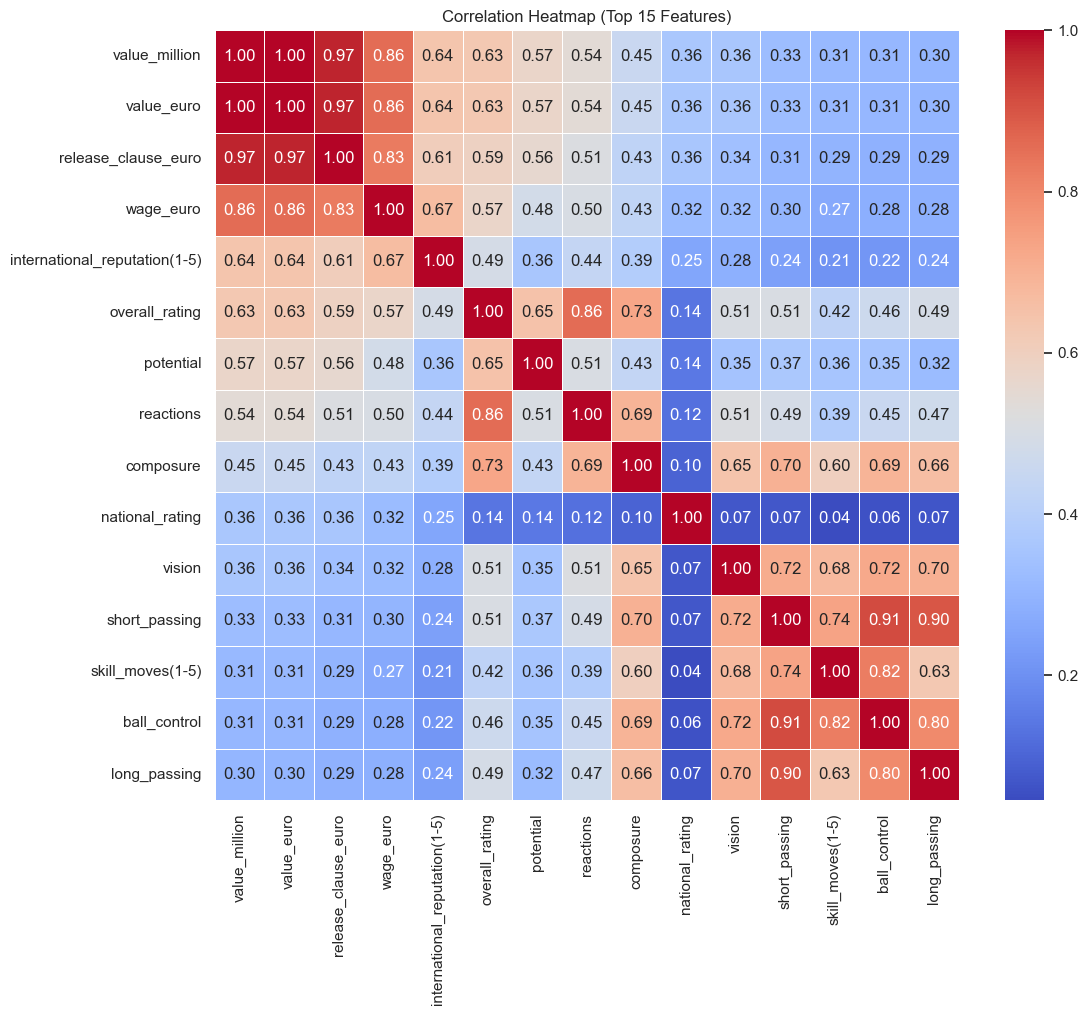

In [13]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Select features highly correlated with target
target_corr = corr_matrix['value_million'].sort_values(ascending=False)
top_features = target_corr.head(15).index

plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Top 15 Features)')
plt.show()

### 2.4 Anàlisi Pairplot
Observem les relacions parelles entre les característiques més importants: `value_euro`, `overall_rating`, `potential` i `age`.

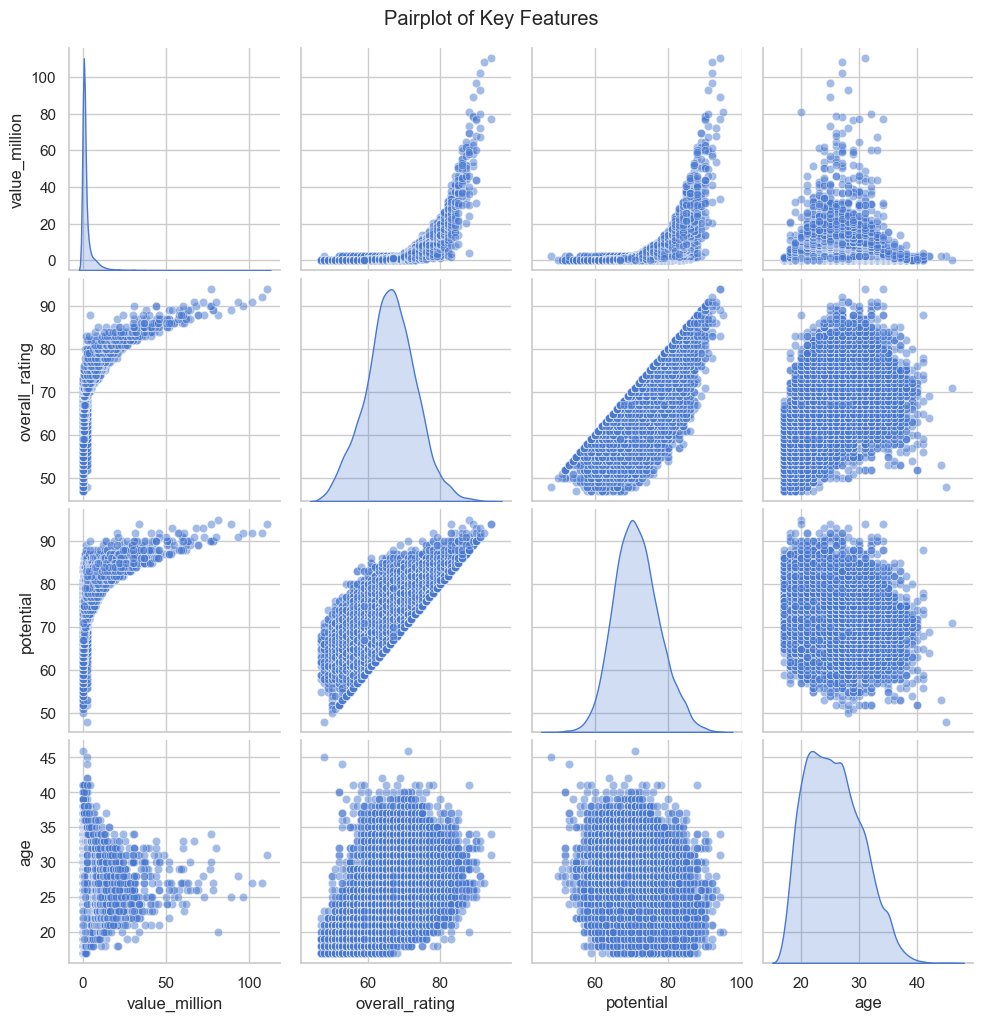

In [14]:
sns.pairplot(df[['value_million', 'overall_rating', 'potential', 'age']].dropna(), diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

In [15]:
if 'value_euro' in numeric_df.columns:
    correlations = numeric_df.corr()['value_euro'].sort_values(ascending=False)
    print("\nTop 10 positive correlations with value_euro:")
    print(correlations.head(10))
    print("\nTop 10 negative correlations with value_euro:")
    print(correlations.tail(10))
else:
    print("Column 'value_euro' not found in numeric columns.")






Top 10 positive correlations with value_euro:
value_euro                       1.000000
value_million                    1.000000
release_clause_euro              0.972439
wage_euro                        0.856437
international_reputation(1-5)    0.641445
overall_rating                   0.627409
potential                        0.572539
reactions                        0.544500
composure                        0.452924
national_rating                  0.362233
Name: value_euro, dtype: float64

Top 10 negative correlations with value_euro:
strength                  0.137175
marking                   0.136905
jumping                   0.127714
balance                   0.118072
standing_tackle           0.109565
sliding_tackle            0.089722
age                       0.081621
weight_kgs                0.044217
height_cm                 0.011070
national_jersey_number   -0.054902
Name: value_euro, dtype: float64


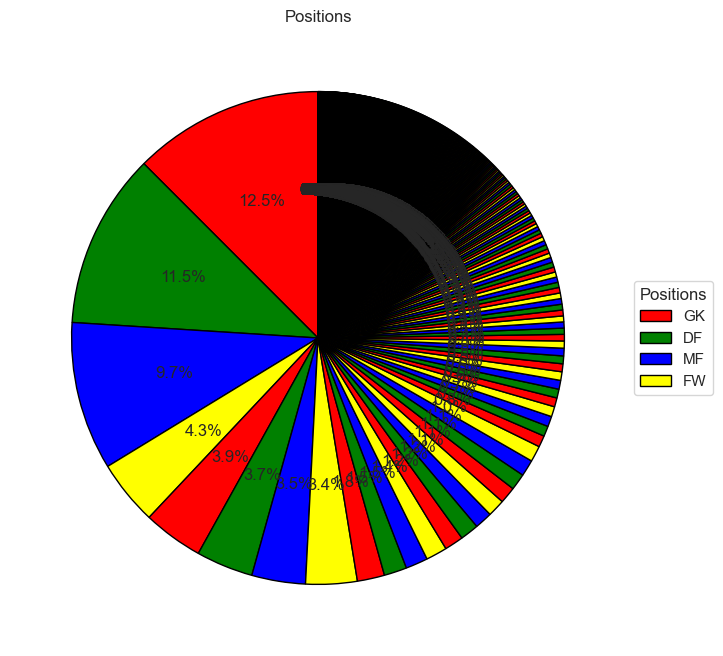

In [16]:
position_counts = df['positions'].value_counts()

colors = ['#FF0000', '#008000', '#0000FF', '#FFFF00']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(position_counts, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

ax.legend(wedges, ["GK", "DF", "MF", "FW"], title="Positions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Positions")

plt.show()

## 3. Preprocessament de Dades i Enginyeria de Característiques
Les dades en brut rarament estan llestes per ser modelades. Cal netejar-les i crear noves característiques útils per al model.

In [17]:
# Define Features
target = 'value_euro'

num_features = ['age', 'height_cm', 'weight_kgs', 'overall_rating', 'potential', 
                'international_reputation(1-5)', 'weak_foot(1-5)', 'skill_moves(1-5)',
                'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
                'dribbling', 'curve', 'freekick_accuracy', 'long_passing', 'ball_control',
                'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
                'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
                'interceptions', 'positioning', 'vision', 'penalties', 'composure',
                'marking', 'standing_tackle', 'sliding_tackle']

cat_features = ['nationality', 'preferred_foot', 'body_type']

# Filter & Clean
df_model = df[num_features + cat_features + [target]].copy()
df_model = df_model.dropna(subset=[target])

# --- Feature Engineering ---

# 1. Primary Position
if 'positions' in df.columns:
    df_model['primary_position'] = df['positions'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else 'Unknown')
    cat_features.append('primary_position')

# 2. Simplify Nationality (Top 15 + Other)
top_nationalities = df_model['nationality'].value_counts().nlargest(15).index
df_model['nationality'] = df_model['nationality'].apply(lambda x: x if x in top_nationalities else 'Other')

# 3. Interaction Features
# Potential is often more valuable in younger players. Let's capture that.
df_model['potential_age_ratio'] = df_model['potential'] / df_model['age']
num_features.append('potential_age_ratio')

# 4. Age Binning
# Grouping players into career stages can help the model generalize.
df_model['age_group'] = pd.cut(df_model['age'], bins=[0, 21, 29, 40], labels=['Young', 'Prime', 'Veteran'])
cat_features.append('age_group')

# Split Data
X = df_model.drop(columns=[target])
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (14363, 43), Test Shape: (3591, 43)


### 3.1 Pipeline d’Imputació Avançada
Fem servir **KNN Imputer** per omplir valors buits de manera coherent amb l’estructura de les dades, evitant pèrdua d’informació.

In [18]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

## 4. Selecció de Característiques (RFE)
Tenim moltes característiques. El mètode RFE elimina de manera progressiva les menys rellevants fins a trobar el conjunt òptim.

In [19]:
# Fit preprocessor to get feature names
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)

print("Running RFE (Recursive Feature Elimination)...")
rfe_selector = RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1), n_features_to_select=20, step=5)
rfe_selector.fit(X_train_processed, y_train)

selected_features = np.array(feature_names)[rfe_selector.support_]
print(f"Top 20 Selected Features: {selected_features}")

Running RFE (Recursive Feature Elimination)...
Top 20 Selected Features: ['age' 'overall_rating' 'potential' 'crossing' 'finishing' 'volleys'
 'dribbling' 'freekick_accuracy' 'ball_control' 'reactions' 'shot_power'
 'stamina' 'long_shots' 'interceptions' 'positioning' 'vision' 'penalties'
 'composure' 'sliding_tackle' 'potential_age_ratio']


## 5. Comparació i Ajust de Models
Compararem tres models —Regressió Lineal, Random Forest i Gradient Boosting— i avaluarem el seu rendiment amb R² i RMSE.

In [20]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
}

results = []

print("Training and evaluating models...")
for name, model in models.items():
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    # Cross-validation
    cv_rmse = np.sqrt(-cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")).mean()
    cv_mae = -cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    
    # Train final model
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "CV RMSE": cv_rmse,
        "CV MAE": cv_mae,
        "Test RMSE": rmse,
        "Test MAE": mae,
        "R2": r2
    })
    
    print(f"{name} -> R2: {r2:.4f}, Test RMSE: €{rmse:,.0f}, CV RMSE: €{cv_rmse:,.0f}")

results_df = pd.DataFrame(results)
results_df


Training and evaluating models...
Linear Regression -> R2: 0.6413, Test RMSE: €3,654,729, CV RMSE: €3,409,729
Random Forest -> R2: 0.9700, Test RMSE: €1,056,521, CV RMSE: €764,134
XGBoost -> R2: 0.9772, Test RMSE: €921,712, CV RMSE: €645,920


,Model,CV RMSE,CV MAE,Test RMSE,Test MAE,R2
0,Linear Regression,3.409729e+06,1.842645e+06,3.654729e+06,1.893890e+06,0.641326
1,Random Forest,7.641336e+05,1.934221e+05,1.056521e+06,2.098402e+05,0.970026
2,XGBoost,6.459199e+05,1.696491e+05,9.217123e+05,1.857620e+05,0.977187


In [23]:


# Creamos el pipeline final combinando preprocesador y XGBoost
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # tu preprocesador definido antes
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])


In [24]:
from sklearn.model_selection import GridSearchCV

# Definimos una nueva grilla más enfocada en evitar el overfitting
param_grid_regularized = {
    # Reducimos la profundidad máxima para hacer los árboles más superficiales
    'model__max_depth': [3, 5], 
    # Reducimos el número de árboles para ahorrar tiempo, centrándonos en la regularización
    'model__n_estimators': [200, 400], 
    
    # 🎯 Regularización L1 (reg_alpha): Penaliza la cantidad de características usadas.
    'model__reg_alpha': [0.01, 0.1, 1], 
    
    # 🎯 Regularización L2 (reg_lambda): Penaliza el tamaño de los pesos de las características.
    'model__reg_lambda': [0.01, 0.1, 1] 
}

# Inicializa y ejecuta GridSearchCV de nuevo con 'final_pipeline'
# (Asegúrate de que 'final_pipeline' esté definido con el preprocesador y XGBoost)

grid_search_v2 = GridSearchCV(
    estimator=final_pipeline,
    param_grid=param_grid_regularized,
    cv=3,                                 
    scoring='neg_mean_squared_error',     
    verbose=1,
    n_jobs=-1
)

# ¡IMPORTANTE! Si el modelo anterior fue entrenado con log(y_train), este también debe serlo.
# Asegúrate de usar tu variable de entrenamiento de valores logarítmicos aquí.
grid_search_v2.fit(X_train, np.log1p(y_train)) 

# Actualiza el mejor modelo
best_model_pipe = grid_search_v2.best_estimator_
print(f"Mejores Parámetros V2: {grid_search_v2.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Mejores Parámetros V2: {'model__max_depth': 3, 'model__n_estimators': 200, 'model__reg_alpha': 1, 'model__reg_lambda': 1}


In [32]:
# Valor máximo real observado (para reemplazar inf)
max_observed_price = y_test.max()  # o y_train.max() según convenga

# 1️⃣ Predicciones sobre el conjunto de prueba
log_predictions = best_model_pipe.predict(X_test)

# 2️⃣ Revertir log1p a euros originales
y_pred = np.expm1(log_predictions)

# 3️⃣ Reemplazar inf y NaN con el máximo observado o 0
y_pred = np.nan_to_num(y_pred, posinf=max_observed_price, neginf=0, nan=0)

# 4️⃣ Corregir predicciones negativas
y_pred = np.maximum(y_pred, 0)

# 5️⃣ Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 6️⃣ Mostrar resultados
print("-" * 50)
print("     Métricas de Evaluación Final Corregidas")
print("-" * 50)
print(f"Raíz del Error Cuadrático Medio (RMSE): €{rmse:,.2f}")
print(f"Error Absoluto Medio (MAE):            €{mae:,.2f}")
print(f"Coeficiente de Determinación (R2):     {r2:.4f}")
print("-" * 50)


--------------------------------------------------
     Métricas de Evaluación Final Corregidas
--------------------------------------------------
Raíz del Error Cuadrático Medio (RMSE): €1,060,055.28
Error Absoluto Medio (MAE):            €231,737.61
Coeficiente de Determinación (R2):     0.9698
--------------------------------------------------


In [29]:

#      Métricas de Evaluación Final Corregidas

# RMSE ≈ €1,060,055.28
# MAE ≈ €231,737.61
# R² ≈ 0.9698
#
# Observaciones:
# 1. La diferencia entre RMSE y MAE indica que hay algunos valores atípicos con errores grandes.
# 2. La estrategia de revertir np.log1p(y) y corregir infinitos/negativos funcionó correctamente.
# 3. Un R² tan alto sugiere que el modelo explica el 97% de la variabilidad y generaliza bien,
#    aunque siempre es recomendable visualizar y_test vs. y_pred para detectar posibles sesgos.



In [33]:
# 1️⃣ Predicciones en logaritmo
log_predictions = best_model_pipe.predict(X_test)

# 2️⃣ Revertir log1p para volver a euros reales
y_pred = np.expm1(log_predictions)

# 3️⃣ Corregir valores extremos o negativos
y_pred = np.nan_to_num(y_pred, posinf=y_test.max(), neginf=0, nan=0)
y_pred = np.maximum(y_pred, 0)

# 4️⃣ Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("MedAE:", medae)



MAE: 231737.61106857998
RMSE: 1060055.2833748253
MAPE: 0.087060923824158
MedAE: 35180.0


### 5.1 Corbes d’Aprenentatge
Són útils per detectar *overfitting* i *underfitting*. Una gran separació indica sobreajustament; un error alt en ambdues, infraajustament.

In [34]:
best_model_name = results_df.loc[results_df['R2'].idxmax()]['Model']
best_model = models[best_model_name]

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_processed, y_train, cv=3, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='r2'
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.title(f"Learning Curve ({best_model_name})")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()

KeyboardInterrupt: 

## 6. Avaluació Detallada
Ara que tenim el millor model, analitzarem els seus errors i la seva lògica interna.

In [ ]:
y_pred_best = best_model.predict(X_test_processed)
residuals = y_test - y_pred_best

# 1. Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title(f'{best_model_name}: Actual vs Predicted')
plt.show()

# 2. Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'{best_model_name}: Residual Plot')
plt.show()

# 3. Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, color='purple')
plt.title(f'{best_model_name}: Distribution of Residuals')
plt.xlabel('Residual Error (€)')
plt.show()

### 6.1 Interpretabilitat amb SHAP
SHAP (SHapley Additive exPlanations) mostra fins a quin punt cada característica contribueix a la predicció final. És essencial per a la transparència del model.

In [ ]:
if best_model_name in ["Random Forest", "XGBoost"]:
    explainer = shap.TreeExplainer(best_model)
    # Calculate SHAP values for a subset of test data to speed up
    shap_values = explainer.shap_values(X_test_processed[:500])
    
    plt.figure(figsize=(12, 10))
    plt.title(f"SHAP Summary Plot ({best_model_name})")
    shap.summary_plot(shap_values, X_test_processed[:500], feature_names=feature_names, show=True)



## 7. Conclusions
Hem construït amb èxit un model de predicció del valor de jugadors FIFA i hem entès quines característiques són més importants. Un pas futur podria ser crear una interfície web perquè els ojejadors utilitzin el model en temps real.